# Artificial Neural Network from Scratch

In this notebook we'll look get a good look implementing a simple neural network, or perceptron. Specifically, we will create a simple, single layer perceptron with only one feature for input.

We'll build this from scratch, then compare it to logistic regression. After that, we'll use PyTorch's functionality to simplify everything - from calculating derivatives with the chain rule to the optimization itself.


### 1: Generate Synthetic Data
We'll first import the necessary Python modules and then generate synthetic data with appropriate size/dimensions. We'll also plot the generated data to see x and y. Note that the y outcomes/labels belong to one of two classes. The positive cases are shown in blue while negative cases are in red.

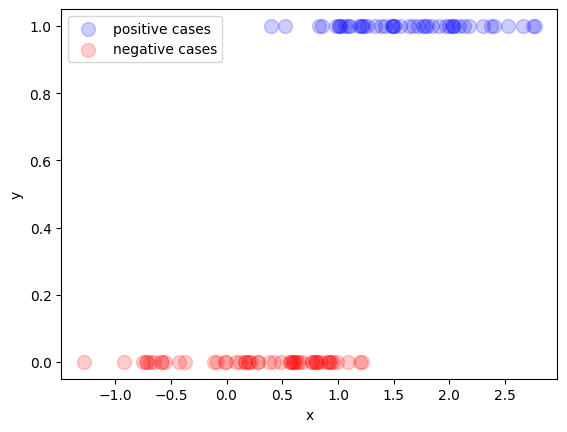

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

N = 100 # total number of observations
D_in = 1 # input dimension (i.e. dimension of a single observation's x vector)
D_out = 1 # output dimension (i.e. y), so just 1 for this example
random.seed(1)
np.random.RandomState(1)

# Create random input data and derive the 'true' labels/output
x = np.random.randn(N, D_in) + 1
def true_y(x_in, n_obs):
    def addNoise(x):
        if abs(x-1) < 1:
            return 0.1
        elif abs(x-1) < 0.1:
            return 0.25
        else:
            return 0.01

    return np.apply_along_axis(lambda x: [int(x[0] < 1) if random.random() < addNoise(x) else int(x[0] > 1)], 1, x_in)

y = true_y(x, N).flatten()

plt.scatter(x[y == 1,0], y[y == 1], c='blue', s=100, alpha=0.2)
plt.scatter(x[y == 0,0], y[y == 0], c='red', s=100, alpha=0.2)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(('positive cases', 'negative cases'))
plt.show()

Let's quickly peek at the x and y data objects (i.e. numpy arrays) to see what their size, shape, and rank look like.

In [2]:
print(f"y.size: {y.size}")
print(f"y.shape: {y.shape}")
print(f"y.ndim: {y.ndim}")

print(f"x.size: {x.size}")
print(f"x.shape: {x.shape}")
print(f"x.ndim: {x.ndim}")

y.size: 100
y.shape: (100,)
y.ndim: 1
x.size: 100
x.shape: (100, 1)
x.ndim: 2


### 2a. Fit Logistic Regression Model

We've already seen that a single layer perceptron with a sigmoid output activation function is equivalent to logisitic regression. So, before we start with the perceptron let's quickly review logistic regression by fitting it to the simulated data we created above.  

That is, let's find estimates for $\beta_0$ and $\beta_1$, which we'll need to be able to predict/estimate the probability that y is in the positive or negative class for any given x.

In traditional statistics there is a large class of models known as [generalized linear models](https://en.wikipedia.org/wiki/Generalized_linear_model), which allow for a linear regression to be used to predict some transformation of the target variable. With logistic regression we transform the target variable, $Y$ (a binary 0 or 1) by looking at the log-odds of the expected value of $y_i$. If we let $p_i be the probability that $y_i$ equals 1, then the log-odds are as follows (note that the log-odds are formally known as the [logit](https://en.wikipedia.org/wiki/Logit) function):

* $\mathrm{logit}(p_i) = ln\Big( \frac{p_i}{1 - p_i} \Big)= \beta_0 + \beta_1*x_i$

Notice that the right side of the formula is in the familiar linear regression format of $\beta$ coefficients and their corresponding $x$ covariates.

When it comes time to make a prediction for a new $y_i$, we'll then use the inverse of the logit function, which happens to be the logistic, or sigmoid, function:

* $p_i = \mathrm{logit}^{-1}\Big( \mathrm{logit}(p_i) \Big) = \mathrm{logit}^{-1}(\beta_0 + \beta_1*x_i) = \frac{1}{1 + e^{-(\beta_0 + \beta_1*x_i)}}$

In [3]:
from sklearn.linear_model import LogisticRegression
logreg_model = LogisticRegression(random_state=42, max_iter=100, tol=1e-3, solver='liblinear')
logreg_model.fit(x, y)

print(f" beta0 = {logreg_model.intercept_[0]:.4f}")
print(f" beta1 = {logreg_model.coef_[0][0]:.4f}")
y_pred = logreg_model.predict_proba(x)
lr_loss = 1/N * np.square(y - y_pred[:,1]).sum()
print(f" loss (mse) = {lr_loss:.4f}")

 beta0 = -2.3962
 beta1 = 2.5532
 loss (mse) = 0.0928


To find those estimates scikit learn's LogisticRegression model solved an optimization problem that we are familiar with, which was to minimize the loss function. Recall that the mean-squared error loss function looks like this:

* $\mathrm{Loss}_{MSE} = \frac{1}{N} \sum_i^N (y_i - p_i)^2$


Note that we've sometimes used $\hat{y}_i$ instead of $p_i$, but they typically considered to be the same quantity (i.e. the direct output of the model).

If we state $p_i$ in terms of our model parameters then, as seen above, we have the following:

* $ \mathrm{Loss}_{MSE} = \frac{1}{N} \sum_i^N \Big( y_i - (1 + e^{-(\beta_0 + \beta_1*x_i)})^{-1} \Big)^2$

By writing the loss function as a function of our model parameters, we can then plot the surface of the loss with $\beta_0$ and $\beta_1$ on the x and y axes, respectively. We can then see where the optimal values might be. Remember that in practice, when we have hundreds, thousands, or more, model parameters, that it is impossible to plot the loss surface in this way.

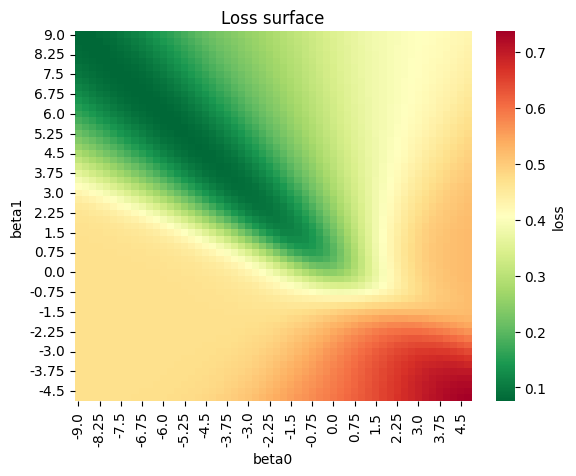

In [4]:
#b1s = np.arange(6, -4.1, -0.5)
#b0s = np.arange(-6, 4.1, 0.5)
b1s = np.arange(9, -5, -0.25)
b0s = np.arange(-9, 5, 0.25)
surf = np.array( [[1/N * np.square(y - 1 / (1 + np.exp(-1 * (b1s[i]*x[:,0] + b0s[j])))).sum() for j in range(len(b0s))] for i in range(len(b1s))] )
df = pd.DataFrame(surf, columns=b0s, index=b1s)
p1 = sns.heatmap(df, cbar_kws={'label': 'loss'}, cmap="RdYlGn_r")
plt.title("Loss surface")
plt.xlabel("beta0")
plt.ylabel("beta1")
plt.show()

Notice above that there does not appear to be one unique pair of values for $\beta_0$, $\beta_1$ that will yield a minimum loss value. That is to say, there is no single point on the surface we plotted above where the loss has an obvivous global minimum. Instead, it looks as if the loss continues to decrease as $\beta_0$ gets smaller and $\beta_1$ gets larger.

What would happen if we chose to use another loss function? Would the log-loss (aka binary cross-entropy) function look much different? The log-loss, or binary cross-entropy function is defined as follows.

* $\mathrm{Loss}_{BCE} = - \sum_i^N \Big( y_i * \mathrm{ln}(\hat{y}_i) + (1 - y_i)*\mathrm{ln}(1-\hat{y}_i) \Big)$

This is a different looking function altogether from the MSE. We would expect, however, that the surface would be similar though so that we would ultimately find similar parameter values. Let's plot this now to see. (Note that in practice the log-loss is the loss function typically used for logistic regression models.)

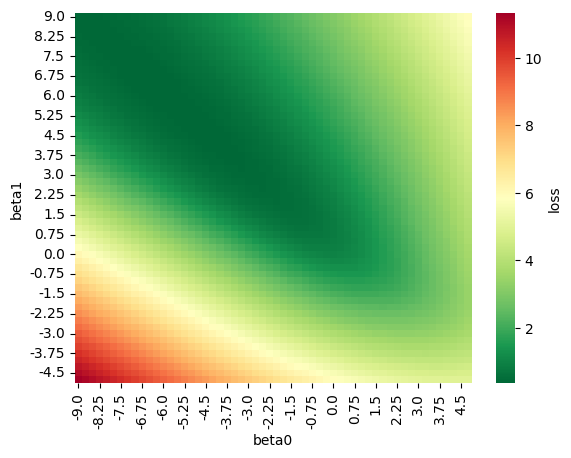

In [5]:
#b1s = np.arange(9, -4.1, -0.5)
#b0s = np.arange(-9, 4.1, 0.5)
b1s = np.arange(9, -5, -0.25)
b0s = np.arange(-9, 5, 0.25)
surf = np.array( [[ -((y * np.log2(1 / (1 + np.exp(-1 * (b1s[i]*x[:,0] + b0s[j])))) + (1-y) * np.log2(1 - 1 / (1 + np.exp(-1 * (b1s[i]*x[:,0] + b0s[j])))))/100).sum() for j in range(len(b0s))] for i in range(len(b1s))] )
df = pd.DataFrame(surf, columns=b0s, index=b1s)
p1 = sns.heatmap(df, cbar_kws={'label': 'loss'}, cmap="RdYlGn_r")
plt.xlabel("beta0")
plt.ylabel("beta1")
plt.show()

Although the two surfaces are noticeably distinct from one another, they do appear to agree on what values of the parameters will minimize the loss. It appears that in both cases the loss will be minimized when $\beta_0$ is a small value (far to the left on the graph) and $\beta_1$ is a large value (up high on the graph).

### 2b: Predict y for a Newly Observed x

Let's see now what the model looks like using the parameter estimates found above (i.e. $\beta_0 = -2.17$, $\beta_1 = 2.55$). Next let's assume we are given a new observation to make a prediction for, and for this new observation we have $x = 1.5$. We can then predict whether it is a positive or negative case by evaluating the logistic function at $x = 1.2$. This yields $\hat{y} \approx 0.7$ (see below).

Since $0.5$ is the typical cutoff value for predicting a positive (vs negative label), and $0.7 > 0.5$, we would likely predict this to be a positive case.

__TIP:__ Try changing the values of the model parameters $\beta_0$ and $\beta_1$ below. Using the plots of the loss surfaces above, try choosing values of the model parameters look like they will yield an even lower point on the surface (i.e. smaller value of loss function). What happens to the plot below when doing so?

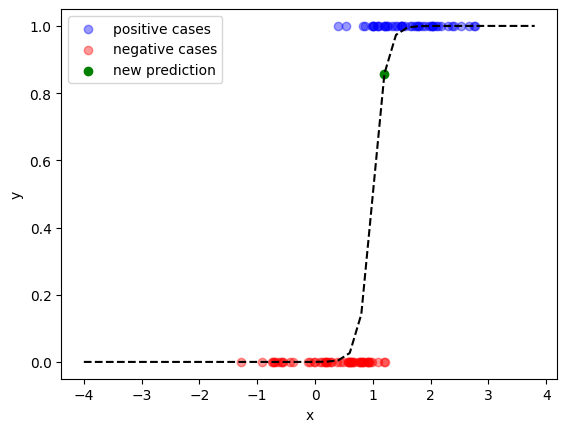

np.float64(0.8581489350995121)

In [7]:
b0 = -9
b1 = 9

plt.scatter(x[y == 1,0], y[y == 1], c='blue', alpha=0.4)
plt.scatter(x[y == 0,0], y[y == 0], c='red', alpha=0.4)
plt.xlabel("x")
plt.ylabel("y")

x_new = 1.2
y_hat_new = 1 / (1 + np.exp(-b0 - b1*x_new))
plt.scatter(x_new, y_hat_new, color="green")
plt.legend(('positive cases', 'negative cases', 'new prediction'), loc='upper left')

xes = np.arange(-4, 4, 0.2)
plt.plot(xes, 1/(1 + np.exp(-b0 - b1*xes)), 'k--')

plt.show()
y_hat_new


### 2c. Why not use Accuracy for Optimization? (instead of MSE or BCE)

At some point you may have asked yourself, "_Why don't we just train our model by optimizing for accuracy?_"

Below is a plot of the surface when using accuracy as the function that the model will optimize for during training. Run the following cell and then answer the questions below.

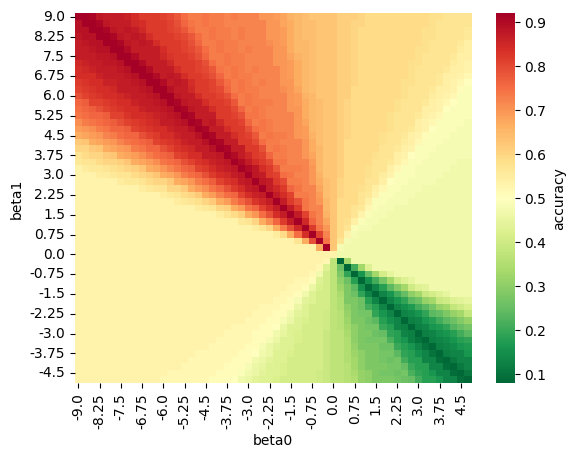

In [8]:
b1s = np.arange(9, -5, -0.25)
b0s = np.arange(-9, 5, 0.25)
def accuracy(b0, b1):
    # calculate the model output for this b0 and b1
    y_hat = 1 / (1 + np.exp(-b0 - b1 * x.flatten()))
    # convert the model output to binary predictions
    y_hat = np.round(y_hat)
    return np.sum(y == y_hat) / len(y)
surf = np.array( [[ accuracy(b0s[j], b1s[i]) for j in range(len(b0s))] for i in range(len(b1s))] )
df = pd.DataFrame(surf, columns=b0s, index=b1s)
p1 = sns.heatmap(df, cbar_kws={'label': 'accuracy'}, cmap="RdYlGn_r")
plt.xlabel("beta0")
plt.ylabel("beta1")
plt.show()

***
### Q1: What is different about using accuracy versus a loss function (e.g. MSE or BCE)?
(Hint: What are the ranges of values that accuracy takes on versus the loss functions? And, which are considered _good_ and which are considered _bad_?)

When it comes to accuracy, you are using values between 0-1, with a more accurate value meaning it is closer to 1 (100%). Loss functions can be measured from 0 - infinity, and you want a lower value (closer to 0) to be considered good.
***

***
### Q2: Assuming you account for what is different about using accuracy versus a loss function, there is still something wrong with using accuracy. What is it? That is, why wouldn't you use accuracy to train a neural network model?
(Hint: How does the accuracy surface differ from the MSE or BCE surfaces? What happens right around b=0, w=0?)

At b=0, and w=0, the accuracy surface is flat. This makes it so that the neural network doesn't have a good path to follow for its training. With MSE and BCE,there is always a measurable loss, and this gradiant decent is what is used for training the nueral network.  
***

### 3. Simple Perceptron w/ NumPy

Using the same $x$ and $y$ data as before we will now see how a simple perceptron network with a sigmoid activiation function is equivalent to the logistic regression model above. Rather than $\beta_0$, $\beta_1$, the parameters to be estimated are generally referred to as the weight and bias terms ($w$ and $b$, respectively). For this simple case they differ only in name though, such that:
* $b = \beta_0$
* $w = \beta_1$

To begin we will manually train the perceptron using numpy and gradient descent to minimize the loss. This will involve taking the derivatives of $w$ and $b$ (using the chain rule) to calculate the gradients in an interative process.


iteration 0: loss = 0.2359, w = 0.0876, b = -0.0752
iteration 50: loss = 0.1292, w = 1.2263, b = -1.0230
iteration 100: loss = 0.1104, w = 1.6701, b = -1.5385
iteration 150: loss = 0.1020, w = 1.9760, b = -1.8781
iteration 200: loss = 0.0971, w = 2.2130, b = -2.1353
 w = 2.4079
 b = -2.3440


[Text(0.5, 0, 'optimization iteration'), Text(0, 0.5, 'parameter: b')]

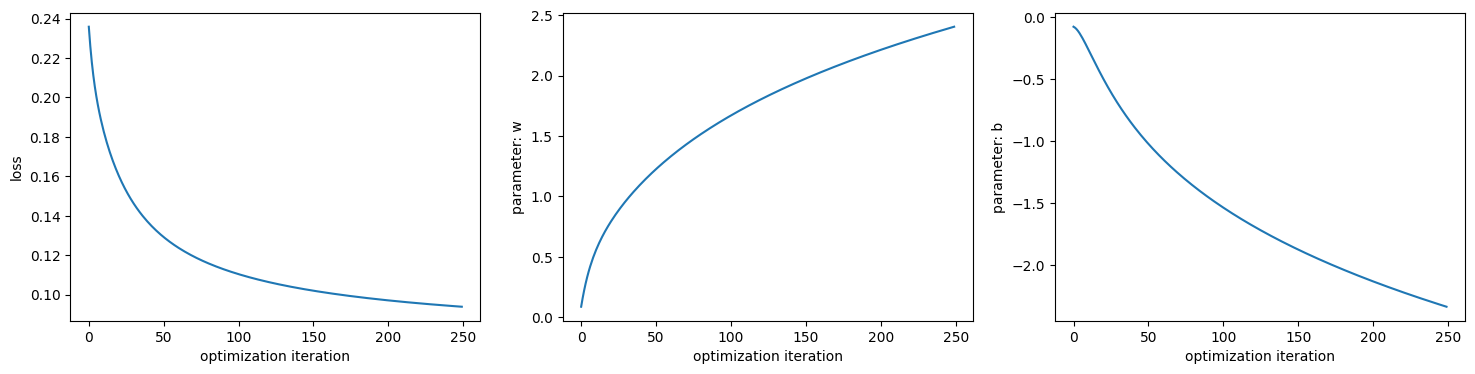

In [9]:
# Randomly initialize parameters to be estimated
#np.random.seed(42)
w = np.random.randn(1)
b = np.random.randn(1)

# learning rate parameter
learning_rate = 5e-1

# keep track of loss to see how the optimization performs
loss = []

params = []

# Begin gradient descent using all of the observations in each iteration
for i in range(250):

    params.append((w[0], b[0]))

    # Forward pass: compute predicted y
    lin_pred = w[0] * x[:,0] + b[0]
    y_pred = 1 / (1 + np.exp(-1 * lin_pred))

    # Compute and store loss, and print occassionally
    loss.append(1/N * np.square(y - y_pred).sum())
    if i % 50 == 0:
        print(f"iteration {i}: loss = {loss[i]:.4f}, w = {w[0]:.4f}, b = {b[0]:.4f}")

    # Backprop to compute gradients of w and b with respect to log loss
    dloss_dypred = -2.0 / N * (y - y_pred)
    dypred_dlinpred = np.exp(-lin_pred) * (1 / np.square(1 + np.exp(-1 * lin_pred)))
    dlinpred_dw = x[:,0]
    dlinpred_db = 1

    # Calculate gradients and update weight and bias parameters
    grad_w = (dloss_dypred * dypred_dlinpred * dlinpred_dw).sum()
    grad_b = (dloss_dypred * dypred_dlinpred * dlinpred_db).sum()
    w -= learning_rate * grad_w # calculate w^(k+1) from w^(k)
    b -= learning_rate * grad_b # calculate b^(k+1) from b^(k)

print(f" w = {w.item():.4f}")
print(f" b = {b.item():.4f}")

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
ax1.plot(range(0,len(loss)), loss)
ax1.set(xlabel="optimization iteration", ylabel="loss")
ax2.plot(range(0,len(params)), [parm[0] for parm in params])
ax2.set(xlabel="optimization iteration", ylabel="parameter: w")
ax3.plot(range(0,len(params)), [parm[1] for parm in params])
ax3.set(xlabel="optimization iteration", ylabel="parameter: b")

***
### Q3: Try running the above code cell a few times. Do you get the exact same parameter value estimates for $b$ and $w$ each time? Explain why or why not?

You do not get the same parameter value estimates for b and w each time. This is due to these lines:
w = np.random.randn(1)
b = np.random.randn(1)

Each time the code is ran, a new value is used to initialize w and b.
***

### 4. Simple Perceptron w/ PyTorch

Now we will train a basic perceptron using PyTorch to take advantage of its ability to perform automatic differentation. This allows us to avoid calculating derivatives manually.

iteration 0: loss = 0.3948, w = 0.2670, b = 1.7269
iteration 50: loss = 0.1581, w = 0.8337, b = -0.5177
iteration 100: loss = 0.1188, w = 1.4411, b = -1.2767
iteration 150: loss = 0.1061, w = 1.8119, b = -1.6972
iteration 200: loss = 0.0996, w = 2.0836, b = -1.9954
 w = 2.3004
 b = -2.2292


[Text(0.5, 0, 'optimization iteration'), Text(0, 0.5, 'parameter: b')]

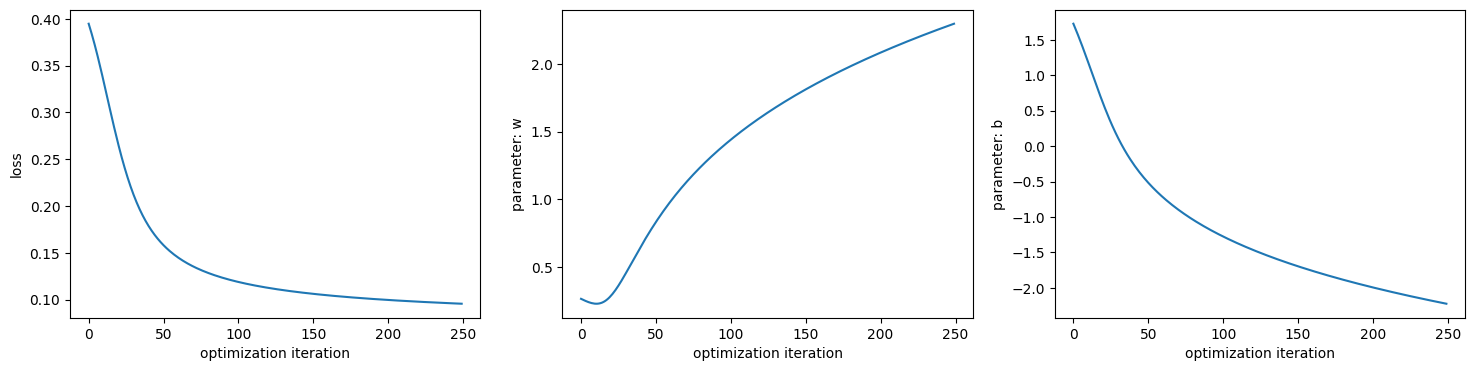

In [10]:
import torch

# Randomly initialize weights and other data
#torch.manual_seed(42)
w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
x_tensor = torch.tensor(x)
y_tensor = torch.tensor(y)
learning_rate = 5e-1
losses = []
params = []

# Carry out gradient descent
for i in range(250):

    params.append((w.item(), b.item()))

    # Forward pass: compute predicted y
    lin_pred = w * x_tensor + b
    y_pred = lin_pred.flatten().sigmoid()

    # Compute and store loss, and print occassionally
    loss = 1/N * (y_tensor - y_pred).pow(2).sum()
    losses.append(loss.item())
    if i % 50 == 0:
        print(f"iteration {i}: loss = {loss.item():.4f}, w = {w[0]:.4f}, b = {b[0]:.4f}")

    loss.backward()

    # Update parameters but don't include these calculations as part of underlying computational graph
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad

    # Reset gradients for next iteration
    w.grad.zero_()
    b.grad.zero_()

print(f" w = {w.item():.4f}")
print(f" b = {b.item():.4f}")

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
ax1.plot(range(0,len(losses)), losses)
ax1.set(xlabel="optimization iteration", ylabel="loss")
ax2.plot(range(0,len(params)), [parm[0] for parm in params])
ax2.set(xlabel="optimization iteration", ylabel="parameter: w")
ax3.plot(range(0,len(params)), [parm[1] for parm in params])
ax3.set(xlabel="optimization iteration", ylabel="parameter: b")

***
### Q4: Run the above code a cell a few times and then try to read it to understand what is happening. Specifically, state which line(s) is calculating the gradients?
Note that the gradients are the derivatives of the objective function with respect to the model parameters (that are then evaluated at the current values of the parameters).


The loss.backward() line is what is calculating the gradiants.
***

### 5: Defining a Perceptron w/ PyTorch

Now we will train a basic perceptron using PyTorch to define the model architecture itself, while continuing to take advantage of its automatic differentation.

iteration 0: loss = 0.2951
iteration 50: loss = 0.1343
iteration 100: loss = 0.1122
iteration 150: loss = 0.1029
iteration 200: loss = 0.0977
parameter values after training:
  param 0 est = 2.3811
  param 1 est = -2.3155


[Text(0.5, 0, 'optimization iteration'), Text(0, 0.5, 'parameter: b')]

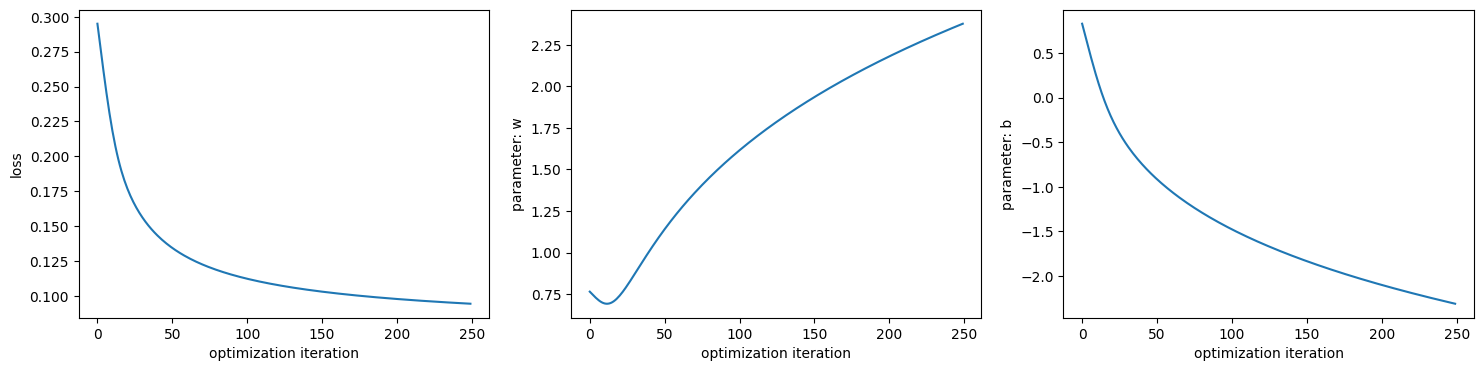

In [11]:
# Randomly initialize weights and other data
torch.manual_seed(42)
#del w #= torch.randn(1, requires_grad=True).reshape(1,1)
#del b #b = torch.randn(1, requires_grad=True).reshape(1,1)
x_tensor = torch.tensor(x).float()
y_tensor = torch.tensor(y).float().reshape(N, D_out)

# Define and declare a pytorch perceptron using sigmoid activation function
model = torch.nn.Sequential(
    torch.nn.Linear(1, 1), # linear layer
    torch.nn.Sigmoid()     # activation function
)

# Define loss function to be used
loss_fn = torch.nn.MSELoss()

learning_rate = 5e-1
losses = []
params = []

# Carry out gradient descent
for i in range(250):

    params.append(tuple([param.item() for param in model.parameters()]))

    # Forward pass: compute predicted y
    y_pred = model.forward(x_tensor)

    # Compute and store loss, and print occassionally
    loss = loss_fn(y_pred, y_tensor)
    losses.append(loss.item())
    if i % 50 == 0:
        print(f"iteration {i}: loss = {loss.item():.4f}")

    model.zero_grad()

    # Backprop using PyTorch's automatic differentiation
    loss.backward()

    # Update parameters but don't include these calculations as part of underlying computational graph
    with torch.no_grad():
        for param in model.parameters():
            param.data -= learning_rate * param.grad

print("parameter values after training:")
for i, param in enumerate(model.parameters()):
    print(f"  param {i} est = {param.item():.4f}")

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
ax1.plot(range(0,len(losses)), losses)
ax1.set(xlabel="optimization iteration", ylabel="loss")
ax2.plot(range(0,len(params)), [parm[0] for parm in params])
ax2.set(xlabel="optimization iteration", ylabel="parameter: w")
ax3.plot(range(0,len(params)), [parm[1] for parm in params])
ax3.set(xlabel="optimization iteration", ylabel="parameter: b")

***
### Q5: Run the above code a cell a few times and then try to read it to understand what is happening. Specifically, state which line(s) is carrying out the Gradient Descent update?


This section of the code us carrying out the Gradient Descent update:
with torch.no_grad():
        for param in model.parameters():
            param.data -= learning_rate * param.grad

***

### 6. Using PyTorch Optimizer

Now we will train a basic perceptron using PyTorch to define the model itself and also to carry out the Adam optimization method (a extension of gradient descent that adaptively estimates gradients to be able to find minima more quickly).


iteration 0: loss = 0.2951
iteration 50: loss = 0.0757
iteration 100: loss = 0.0756
iteration 150: loss = 0.0756
iteration 200: loss = 0.0756
w and b estimates:
    7.7210
    -7.7180


[Text(0.5, 0, 'optimization iteration'), Text(0, 0.5, 'parameter: b')]

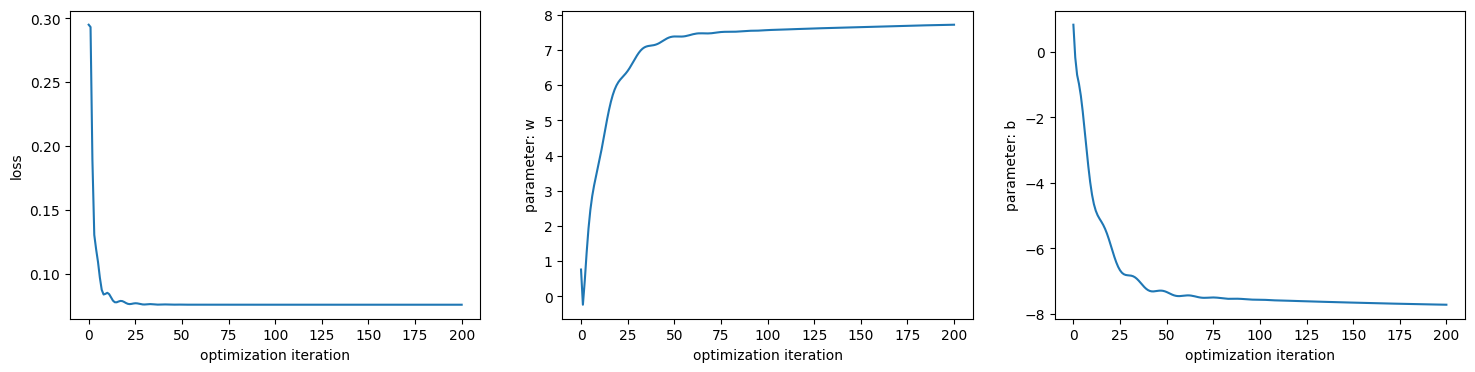

In [15]:
# Randomly initialize weights and other data
torch.manual_seed(42)
x_tensor = torch.tensor(x).float()
y_tensor = torch.tensor(y).float().reshape(N, D_out)

# Declare a perceptron instance
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
    torch.nn.Sigmoid()
)

# Define loss function to be used
loss_fn = torch.nn.MSELoss()
#loss_fn = torch.nn.BCELoss()

learning_rate = 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
params = []

# Carry out gradient descent
for i in range(200 + 1):

    params.append(tuple([param.item() for param in model.parameters()]))

    # Forward pass: compute predicted y
    y_pred = model.forward(x_tensor)

    # Compute and store loss, and print occassionally
    loss = loss_fn(y_pred, y_tensor)
    losses.append(loss.item())
    if i % 50 == 0:
        print(f"iteration {i}: loss = {loss.item():.4f}")

    # Zero all gradients before backward pass
    optimizer.zero_grad()

    # Backprop then call optimizer step to update all (relevant) model parameters for us
    loss.backward()
    optimizer.step() # this calculates w(k+1) for us (for all parameters)

print("w and b estimates:")
for param in model.parameters():
    print(f"    {param.item():.4f}")

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
ax1.plot(range(0,len(losses)), losses)
ax1.set(xlabel="optimization iteration", ylabel="loss")
ax2.plot(range(0,len(params)), [parm[0] for parm in params])
ax2.set(xlabel="optimization iteration", ylabel="parameter: w")
ax3.plot(range(0,len(params)), [parm[1] for parm in params])
ax3.set(xlabel="optimization iteration", ylabel="parameter: b")

***
### Q6: Run the above code a cell a few times and then try changing the learning rate above to a larger value. How many epochs are then needed to get the loss below 0.10? Is it possible to get the loss below 0.05?

With larger learning rates (I used .5 and 1) you only need 5-15 epochs to get the loss below .10. With the original learning rate, you need close to 100. No amount of training is possible to get loss below .05, the lowest I could get it was about .075.

***


### 6. Using PyTorch's torch.nn.Module Base Class
Finally, let's make use of the PyTorch base class for creating a neural network. The `torch.nn.Module` class is the base class that we will inherit from to create a neural network. Notice that to start we override the constructor, `__init__`, and that inside this method we define the various layers to our neural network. We can then define the `forward` method to behave specifically how we choose. In the example below we pass an additional flag to the `forward()` method to either calculate and return the final predicted probability (with `apply_sigmoid=True`) or to simply return the linear predictor (with `apply_sigmoid=False`). This can be useful for us in some instances. For example, the log-loss function (aka binary cross-entropy) can execute slightly more efficiently by taking advantage of the fact that the `log` and `exp` functions are inverses of one another (recall that the sigmoid function has `exp()` in it).

iteration 0: loss = 0.7854
iteration 50: loss = 0.2516
iteration 100: loss = 0.2509
iteration 150: loss = 0.2509
iteration 200: loss = 0.2509
w and b estimates:
   5.8453
   -5.7423


[Text(0.5, 0, 'optimization iteration'), Text(0, 0.5, 'parameter: b')]

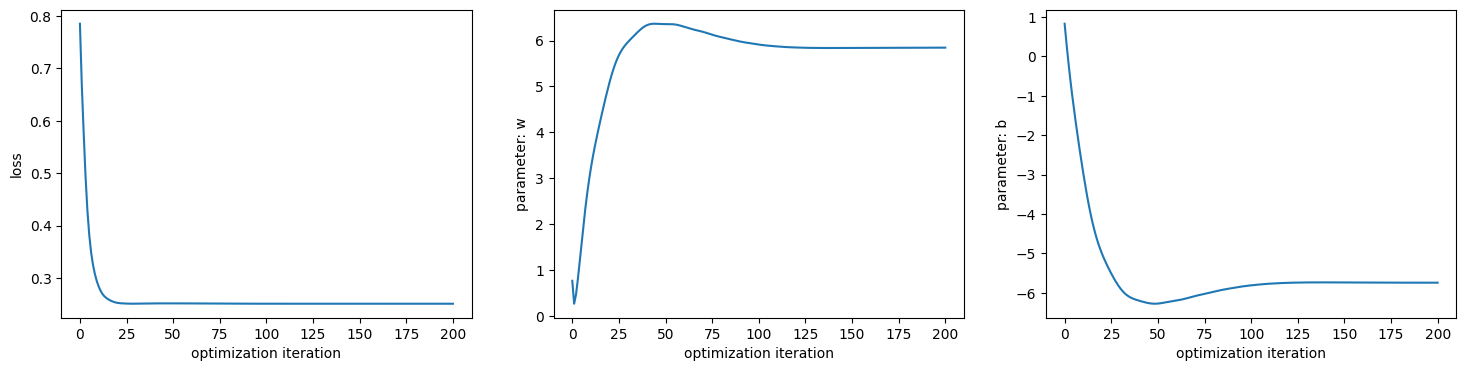

In [16]:
# Randomly initialize weights and other data
torch.manual_seed(42)
#w = torch.randn(1, requires_grad=True).reshape(1,1)
#b = torch.randn(1, requires_grad=True).reshape(1,1)
x_tensor = torch.tensor(x).float()
y_tensor = torch.tensor(y).float().reshape(N, D_out)

# Define our own ANN class
class Perceptron(torch.nn.Module):
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.lay1 = torch.nn.Linear(input_dim, 1) # linear layer
        self.act = torch.nn.Sigmoid()             # activation layer
    def forward(self, x, apply_sigmoid=False):
        output = self.lay1(x)
        if apply_sigmoid:
            output = self.act(output)
        return output

model = Perceptron(1)

# Define loss function to be used
#loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.BCELoss()
#loss_fn = torch.nn.BCEWithLogitsLoss() # expects only linear predictor (w/o sigmoid applied)
learning_rate = 5e-1

# define optimizer to be used and tell it about the model's parameters
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
params = []

# Carry out gradient descent
for i in range(200+1):

    params.append(tuple([param.item() for param in model.parameters()]))

    # Forward pass: compute predicted y
    y_pred = model.forward(x_tensor, apply_sigmoid=True) #False)

    # Compute and store loss, and print occassionally
    loss = loss_fn(y_pred, y_tensor)

    losses.append(loss.item())
    if i % 50 == 0:
        print(f"iteration {i}: loss = {loss.item():.4f}") #" w = {w[0]:.4f}, b = {b[0]:.4f}")

    # Zero all gradients before backward pass
    optimizer.zero_grad()

    # Backpropagation: calculate loss for each model parameter and have optimizer update all of them
    loss.backward()
    optimizer.step()

print("w and b estimates:")
for param in model.parameters():
    print(f"   {param.item():.4f}")

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
ax1.plot(range(0,len(losses)), losses)
ax1.set(xlabel="optimization iteration", ylabel="loss")
ax2.plot(range(0,len(params)), [parm[0] for parm in params])
ax2.set(xlabel="optimization iteration", ylabel="parameter: w")
ax3.plot(range(0,len(params)), [parm[1] for parm in params])
ax3.set(xlabel="optimization iteration", ylabel="parameter: b")